In [1]:
import jax.numpy as np
from jax.numpy import pi as pi
from jax.experimental.ode import odeint

In [2]:
# Kinetic and general parameters

R = 8.314e6                 # [Pa.cm³/(K.mol.)]
k1 = 0.04                   # [s-¹]
k1_Inv = 6.40e6             # [cm³/s-mol]
k2 = 4.20                   # [s-¹]
k2_Inv = 56.38              # [cm³/s-mol]

    
# Molecular weights
MM_B = 78.00     #[g/mol] 

# Fixed Reactor Values
T = 1173.15                 # Temperature[K]  =900[°C] (Isothermal)
Q = 3600 * 0.01e-4          # [mol/(h.cm².atm1/4)]
selec = 1500

# Tube side
Pt = 101325.0               # Pressure [Pa](1atm)
v0 = 3600 * (2 / 15)        # Vol. Flow rate [cm³ h-¹]
Ft0 = Pt * v0 / (R * T)     # Initial molar flow rate[mol/h] - Pure CH4

# Shell side
Ps = 101325.0               # Pressure [Pa](1atm)
ds = 3                      # Diameter[cm]
v_He = 3600 * (1 / 6)       # Vol. flow rate[cm³/h]
F_He = Ps * v_He / (R * T)  # Sweep gas molar flow rate [mol/h]

In [3]:
def dma_mr_model(F, z, dt):

    At = 0.25 * np.pi * (dt ** 2)  # Cross sectional area[cm³]
    
    # Avoid negative flows that can happen in the first integration steps.
    # Consequently this avoids that any molar balance (^ 1/4 terms) generates
    # complex numbers.
    F = np.where(F <= 1e-9, 1e-9, F)
    

    
    # Evaluate total flow rate in tube & shell.
    Ft = F[0:4].sum()
    Fs = F[4:].sum() + F_He
    v = v0 * (Ft / Ft0)

    # Concentrations from molar flow rates [mol/cm3]
    C = F[:4] / v
    # Partial pressures - Tube & Shell [mol/cm3]

    P0t = (Pt / 101325) * (F[0] / Ft)
    P1t = (Pt / 101325) * (F[1] / Ft)
    P2t = (Pt / 101325) * (F[2] / Ft)
    P3t = (Pt / 101325) * (F[3] / Ft)

    P0s = (Ps / 101325) * (F[4] / Fs)
    P1s = (Ps / 101325) * (F[5] / Fs)
    P2s = (Ps / 101325) * (F[6] / Fs)
    P3s = (Ps / 101325) * (F[7] / Fs)
    
    

    
    r0 = 3600 * k1 * C[0] * (1 - ((k1_Inv * C[1] * C[2] ** 2) / 
                                  (k1 * (C[0])**2 )))
    

    # This replicates an if statement whenever the concentrations are near zero
    C0_aux = C[0]
    r0 = np.where(C0_aux <= 1e-9, 0, r0)
    
    r1 = 3600 * k2 * C[1] * (1 - ((k2_Inv * C[3] * C[2] ** 3) / 
                                  (k2 * (C[1])**3 )))
    

    # Same as before
    C1_aux = C[1]
    r1 = np.where(C1_aux <= 1e-9 , 0, r1)  

    # Molar balances adjustment with experimental data.
    eff = 0.9
    vb = 0.5
    Cat = (1 - vb) * eff

    # Molar balances dFdz - Tube (0 to 3) & Shell (4 to 7)
    dF0 = -Cat * r0 * At - (Q / selec) * ((P0t ** 0.25) - (P0s ** 0.25)) * pi * dt
    dF1 = 1 / 2 * Cat * r0 * At - Cat * r1 * At - (Q / selec) * ((P1t ** 0.25) - (P1s ** 0.25)) * pi * dt
    dF2 = Cat * r0 * At + Cat * r1 * At- (Q) * ((P2t ** 0.25) - (P2s ** 0.25)) * pi * dt
    dF3 = (1 / 3) * Cat * r1 * At - (Q / selec) * ((P3t ** 0.25) - (P3s ** 0.25)) * pi * dt
    dF4 = (Q / selec) * ((P0t ** 0.25) - (P0s ** 0.25)) * pi * dt
    dF5 = (Q / selec) * ((P1t ** 0.25) - (P1s ** 0.25)) * pi * dt
    dF6 = (Q) * ((P2t ** 0.25) - (P2s ** 0.25)) * pi * dt
    dF7 = (Q / selec) * ((P3t ** 0.25) - (P3s ** 0.25)) * pi * dt
    
    dFdz = np.array([ dF0, dF1, dF2, dF3, dF4, dF5, dF6, dF7 ])

    return dFdz

In [4]:
def dma_mr_design(u):

    L =  u[0]
    dt = u[1]

    # Initial conditions
    y0 = np.hstack((Ft0, np.zeros(7)))
    rtol, atol = 1e-10, 1e-10

    # Integration of mol balances using Jax's Dormand Prince
    z = np.linspace(0, L, 2000)
    F = odeint(dma_mr_model, y0, z, dt, rtol=rtol, atol=atol)
    
    # Calculating outputs (AOS/DOS) from states.
    F_C6H6 = ((F[-1, 3] * 1000) * MM_B)
    X_CH4  = (100 * (Ft0 - F[-1, 0] - F[-1, 4]) / Ft0)

    return np.array([F_C6H6, X_CH4])

In [5]:
from pypo import nlp_based_approach

In [6]:
# Lower and upper bounds for DOS definition
DOS_bounds = np.array([[15,25],
                       [35,45]])

# Discretization Grid - 10x10 grid for DOS.
DOS_resolution =  [10, 10]

# Lower and upper bounds of AIS design variables.
lb = np.array([10,  0.1])
ub = np.array([300, 2])

# Initial estimate for NLP.
u0 = np.array([50, 1])

In [7]:
# Plug-flow constraint definition: Length/Diameter >= 30.
def plug_flow(u):
    return u[0] - 30.0*u[1]

con= {'type': 'ineq', 'fun': plug_flow}

 You have selected automatic differentiation as a method for obtaining higher-order data (Jacobians/Hessian). Make sure your process model is JAX-compatible implementation-wise.


  0%|                                                                                                                                                                                     | 0/100 [00:00<?, ?it/s]

  1%|█▋                                                                                                                                                                           | 1/100 [00:15<25:40, 15.56s/it]

  2%|███▍                                                                                                                                                                         | 2/100 [00:23<17:55, 10.97s/it]

  3%|█████▏                                                                                                                                                                       | 3/100 [00:26<12:08,  7.52s/it]

  4%|██████▉                                                                                                                                                                      | 4/100 [00:28<08:24,  5.26s/it]

  5%|████████▋                                                                                                                                                                    | 5/100 [00:30<06:31,  4.12s/it]

  6%|██████████▍                                                                                                                                                                  | 6/100 [00:37<07:49,  5.00s/it]

  7%|████████████                                                                                                                                                                 | 7/100 [00:39<06:08,  3.96s/it]

  8%|█████████████▊                                                                                                                                                               | 8/100 [00:50<09:42,  6.33s/it]

  9%|███████████████▌                                                                                                                                                             | 9/100 [00:59<11:04,  7.31s/it]

 10%|█████████████████▏                                                                                                                                                          | 10/100 [01:03<08:59,  6.00s/it]

 11%|██████████████████▉                                                                                                                                                         | 11/100 [01:08<08:25,  5.68s/it]

 12%|████████████████████▋                                                                                                                                                       | 12/100 [01:10<06:58,  4.76s/it]

 13%|██████████████████████▎                                                                                                                                                     | 13/100 [01:13<06:10,  4.26s/it]

 14%|████████████████████████                                                                                                                                                    | 14/100 [01:19<06:48,  4.75s/it]

 15%|█████████████████████████▊                                                                                                                                                  | 15/100 [01:22<05:44,  4.06s/it]

 16%|███████████████████████████▌                                                                                                                                                | 16/100 [01:24<04:59,  3.57s/it]

 17%|█████████████████████████████▏                                                                                                                                              | 17/100 [01:26<04:08,  2.99s/it]

 18%|██████████████████████████████▉                                                                                                                                             | 18/100 [01:38<07:54,  5.78s/it]

 19%|████████████████████████████████▋                                                                                                                                           | 19/100 [01:45<08:26,  6.25s/it]

 20%|██████████████████████████████████▍                                                                                                                                         | 20/100 [01:48<07:00,  5.26s/it]

 21%|████████████████████████████████████                                                                                                                                        | 21/100 [01:52<06:08,  4.67s/it]

 22%|█████████████████████████████████████▊                                                                                                                                      | 22/100 [01:53<04:52,  3.75s/it]

 23%|███████████████████████████████████████▌                                                                                                                                    | 23/100 [02:00<05:54,  4.61s/it]

 24%|█████████████████████████████████████████▎                                                                                                                                  | 24/100 [02:02<04:50,  3.82s/it]

 25%|███████████████████████████████████████████                                                                                                                                 | 25/100 [02:04<04:09,  3.33s/it]

 26%|████████████████████████████████████████████▋                                                                                                                               | 26/100 [02:06<03:33,  2.88s/it]

 27%|██████████████████████████████████████████████▍                                                                                                                             | 27/100 [02:18<07:03,  5.80s/it]

 28%|████████████████████████████████████████████████▏                                                                                                                           | 28/100 [02:21<05:43,  4.77s/it]

 29%|█████████████████████████████████████████████████▉                                                                                                                          | 29/100 [02:23<04:48,  4.07s/it]

 30%|███████████████████████████████████████████████████▌                                                                                                                        | 30/100 [02:32<06:27,  5.53s/it]

 31%|█████████████████████████████████████████████████████▎                                                                                                                      | 31/100 [02:36<05:56,  5.16s/it]

 32%|███████████████████████████████████████████████████████                                                                                                                     | 32/100 [02:40<05:12,  4.59s/it]

 33%|████████████████████████████████████████████████████████▊                                                                                                                   | 33/100 [02:43<04:48,  4.31s/it]

 34%|██████████████████████████████████████████████████████████▍                                                                                                                 | 34/100 [02:47<04:41,  4.26s/it]

 35%|████████████████████████████████████████████████████████████▏                                                                                                               | 35/100 [02:52<04:46,  4.41s/it]

 36%|█████████████████████████████████████████████████████████████▉                                                                                                              | 36/100 [02:56<04:29,  4.22s/it]

 37%|███████████████████████████████████████████████████████████████▋                                                                                                            | 37/100 [03:05<05:51,  5.59s/it]

 38%|█████████████████████████████████████████████████████████████████▎                                                                                                          | 38/100 [03:12<06:21,  6.15s/it]

 39%|███████████████████████████████████████████████████████████████████                                                                                                         | 39/100 [03:15<05:14,  5.16s/it]

 40%|████████████████████████████████████████████████████████████████████▊                                                                                                       | 40/100 [03:18<04:33,  4.56s/it]

 41%|██████████████████████████████████████████████████████████████████████▌                                                                                                     | 41/100 [03:21<04:04,  4.15s/it]

 42%|████████████████████████████████████████████████████████████████████████▏                                                                                                   | 42/100 [03:25<03:44,  3.87s/it]

 43%|█████████████████████████████████████████████████████████████████████████▉                                                                                                  | 43/100 [03:28<03:33,  3.75s/it]

 44%|███████████████████████████████████████████████████████████████████████████▋                                                                                                | 44/100 [03:31<03:09,  3.39s/it]

 45%|█████████████████████████████████████████████████████████████████████████████▍                                                                                              | 45/100 [03:34<03:07,  3.41s/it]

 46%|███████████████████████████████████████████████████████████████████████████████                                                                                             | 46/100 [03:38<03:12,  3.57s/it]

 47%|████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 47/100 [03:43<03:38,  4.11s/it]

 48%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 48/100 [03:46<03:03,  3.52s/it]

 49%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 49/100 [03:48<02:42,  3.19s/it]

 50%|██████████████████████████████████████████████████████████████████████████████████████                                                                                      | 50/100 [03:51<02:29,  3.00s/it]

 51%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 51/100 [03:56<02:55,  3.58s/it]

 52%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 52/100 [03:57<02:24,  3.00s/it]

 53%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 53/100 [04:00<02:15,  2.88s/it]

 54%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 54/100 [04:03<02:13,  2.90s/it]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 55/100 [04:05<02:05,  2.79s/it]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 56/100 [04:08<02:02,  2.78s/it]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 57/100 [04:12<02:12,  3.09s/it]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 58/100 [04:14<01:53,  2.71s/it]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 59/100 [04:15<01:36,  2.36s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 60/100 [04:17<01:31,  2.29s/it]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 61/100 [04:19<01:27,  2.24s/it]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 62/100 [04:25<01:58,  3.11s/it]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 63/100 [04:25<01:30,  2.44s/it]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 64/100 [04:27<01:17,  2.14s/it]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 65/100 [04:28<01:04,  1.85s/it]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 66/100 [04:30<01:06,  1.95s/it]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 67/100 [04:31<00:56,  1.70s/it]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 68/100 [04:33<00:49,  1.55s/it]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 69/100 [04:34<00:45,  1.46s/it]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 70/100 [04:35<00:41,  1.40s/it]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 71/100 [04:37<00:48,  1.69s/it]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 72/100 [04:38<00:39,  1.41s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 73/100 [04:39<00:32,  1.21s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 74/100 [04:40<00:28,  1.10s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 75/100 [04:41<00:26,  1.06s/it]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 76/100 [04:42<00:26,  1.12s/it]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 77/100 [04:43<00:27,  1.21s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 78/100 [04:44<00:23,  1.08s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 79/100 [04:45<00:23,  1.13s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 80/100 [04:47<00:24,  1.25s/it]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 81/100 [04:49<00:28,  1.52s/it]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 82/100 [04:50<00:23,  1.33s/it]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 83/100 [04:51<00:19,  1.17s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 84/100 [04:52<00:16,  1.04s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 85/100 [04:52<00:15,  1.00s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 86/100 [04:54<00:14,  1.07s/it]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 87/100 [04:58<00:27,  2.14s/it]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 88/100 [04:59<00:20,  1.72s/it]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 89/100 [05:00<00:15,  1.43s/it]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 90/100 [05:01<00:13,  1.31s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 91/100 [05:03<00:13,  1.46s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 92/100 [05:03<00:09,  1.24s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 93/100 [05:04<00:08,  1.17s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 94/100 [05:05<00:06,  1.08s/it]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 95/100 [05:06<00:05,  1.09s/it]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 96/100 [05:08<00:04,  1.11s/it]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 97/100 [05:09<00:03,  1.18s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 98/100 [05:10<00:02,  1.06s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 99/100 [05:10<00:00,  1.01it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:11<00:00,  1.04it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:11<00:00,  3.12s/it]

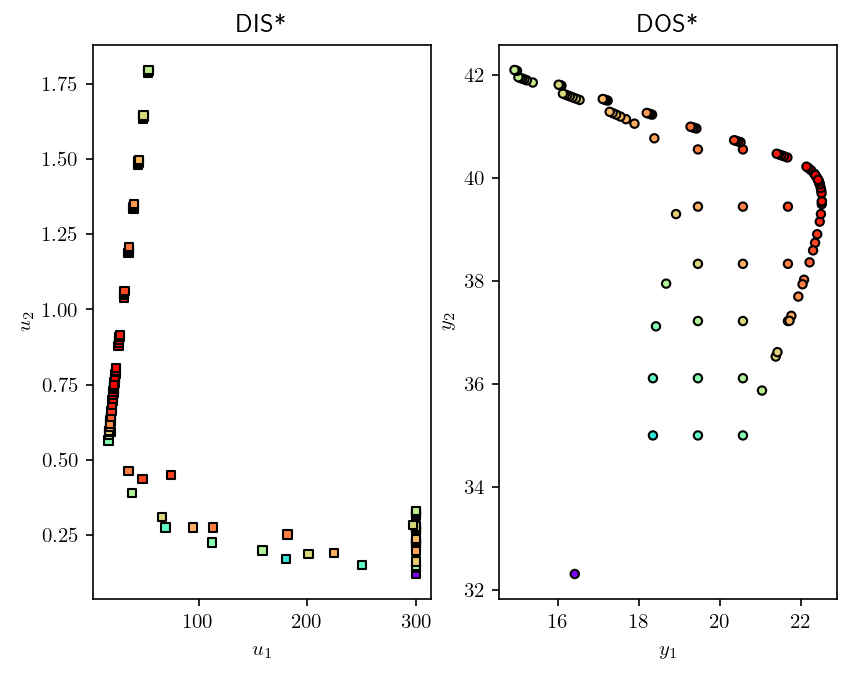

In [8]:
# Model assignment: Design Problem - Inverse mapping
# Obtain inverse mapping.                                                 
fDIS, fDOS, convergence = nlp_based_approach(DOS_bounds, 
                                             DOS_resolution,
                                             dma_mr_design, 
                                             u0,
                                             lb,
                                             ub,
                                             constr=(con),
                                             method='ipopt',
                                             plot=True,
                                             ad=True,
                                             warmstart=True)